# Classification Algorithms 

Bu calismada asagidaki 4 algoritma uzerine model kurulup karsilastirilmasi gerceklestirildi. Bolum 4.5 kisminda karsilastirmali kiyaslamasi mevcuttur.

- Decision Tree
- Random Forest 
- Neural Networks
- Logistic Regression

In [7]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn import tree 
import timeit
from warnings import filterwarnings
filterwarnings('ignore')

In [8]:
def nulldata_check(data):
    count = data.isnull().sum().sort_values(ascending=True).to_frame()
    percent = (data.isnull().sum().sort_values(ascending=True)/data["bad"].count()).to_frame().round(decimals=4)
    df = pd.concat([count, percent], axis=1)
    df.columns = ["count","percentage"]
    return df

def crosstab(index, col, normalize="columns"):
    return pd.crosstab(index, col, normalize=normalize)

def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

In [9]:
def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def sortDifferentCategory(data):
    def takeSecond(elem):
        return elem[1]

    listem = []
    for i in data.select_dtypes(include=["object", "int64", "float64"]).columns:
        listem.append([i, data[i].value_counts().count()])

    return sorted(listem, key=takeSecond ,reverse=False)


In [10]:
def layer1(data_norm, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data_norm.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df

def layer2(new_df, target, num_feats):
    x = new_df.drop([target], axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

def featureselection_corrcorr(data, target, threshold, num_feat):
    layer1_df = layer1(data, target, threshold)
    last_features = layer2(layer1_df, target, num_feat)
    reduced_df = data[last_features]
    reduced_df[target] = data[target]
    return reduced_df

In [11]:
def featureselection_pca(data_minmax, target, threshold):
    x = data_minmax.drop([target], axis=1)
    y = data_minmax[target]
    pca = PCA()    
    X_pca = pca.fit_transform(x)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = x.index)
    X_pcad[target] = y
    return X_pcad

def featureselection_randomforest(xtrain,ytrain, params, top_feat, cv=10, n_jobs=-1, verbose=2):
    model = RandomForestClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_features = grid_cv_model.best_params_["max_features"] 
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.min_samples_split= grid_cv_model.best_params_["min_samples_split"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    #y_pred = model_tuned.predict(xtest)
    
    importance = pd.DataFrame({"importance": model.feature_importances_*100}, index = xtrain.columns)
    rf_columns = importance.sort_values(by="importance", axis=0, ascending=False).head(top_feat).index
    new_df = xtrain[rf_columns]
    new_df["bad"] = ytrain
    return new_df

In [12]:
def describe(data):
    desc_df = data.describe().T
    null_count = data.isnull().sum()
    null_percent = (data.isnull().sum() / data.count())*100
    variance = data.var()

    desc_df["variance"] =  round(variance,3)
    desc_df["null_values"] = round(null_count,3)
    desc_df["null__rate"] = round(null_percent,3)
    return desc_df.T

def normalization_minmax(dataframe):
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(dataframe)
    array = scaler.transform(dataframe)
    data_minmax = pd.DataFrame(array, columns=dataframe.columns)
    return data_minmax

def evaluation_metrics(ytest, y_pred):
    print("accuracy : ", round(accuracy_score(ytest,y_pred),5),
      "\nprecision: ", round(precision_score(ytest,y_pred),5),
      "\nrecall   : ", round(recall_score(ytest,y_pred),5),
      "\nf1-score : ", round(f1_score(ytest,y_pred),5))

# **1. Data Exploration**

### **1.1.  Veri Degiskenlerinin Aciklanmasi**

**BAD:** BAD değişkeni veri setinde hedef değişkenidir. **'1'** kişinin borcunu zamanında ve usulüne göre yerine getirmediği durum. **'0'** kredi borcunu zamanında ödemiş. 

**LOAN:** Bankadan talep ettiği kredi miktarı 

**MORTDUE:** İpotek için ödemesi gereken tutar

**VALUE:** Müşterinin geçerli mülk değeri

**REASON:** **DebtCont=** diğer borç yükümlülükleri için alınan borç. **HomeImp=** Kişisel ev ihtiyaçları için alınan borç 

**JOB:** Müşterinin meslek (kategorik veri)

**YOJ:** Mevcut mesleğinde kaç yıldır çalışıyor

**DEROG:** Kredi almasını etkileyen önemli zararlı/uygunsuz rapor sayısı

**DELINQ:** Zamanında ödenmemiş kredi sayısı

**CLAGE:** Aylar içinde en eski kredi limitinin yaşı

**NINQ:** Kredi ile ilgili son yapılan sorgu sayısı

**CLNO:** Kredi limitinin sayısı 

**DEBTINC:** Müşterinin borç-gelir oranı 

In [14]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Veri-Bilimi-Bootcamp/hmelq.csv")
data.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,0,81200,18834.0,108355.0,HomeImp,NaN,28.0,0.0,0.0,139.14,0.0,14.0,34.042
1,0,12600,103960.0,127384.0,DebtCon,NaN,2.0,0.0,0.0,129.02,0.0,25.0,34.479
2,0,18000,46865.0,61266.0,DebtCon,NaN,5.0,0.0,0.0,102.59,2.0,9.0,26.354
3,0,10300,57676.0,71027.0,DebtCon,NaN,19.0,0.0,0.0,157.52,1.0,11.0,33.992
4,0,9400,56508.0,78358.0,DebtCon,NaN,17.0,0.0,0.0,141.93,0.0,11.0,32.327


### **1.2. Verilerin Istatistiksel Dagilimi**

In [15]:
print("Shape: ", data.shape)
describe(data).T

Shape:  (3576, 13)


,count,mean,std,min,25%,50%,75%,max,variance,null_values,null__rate
bad,3576.0,0.199385,0.399594,0.00,0.00,0.000,0.00,1.000,1.600000e-01,0.0,0.000
loan,3576.0,18529.697987,11262.834060,1100.00,11000.00,16200.000,23100.00,89900.000,1.268514e+08,0.0,0.000
mortdue,3262.0,74013.907992,44016.833772,2619.00,46700.25,65858.000,91717.00,399550.000,1.937482e+09,314.0,9.626
value,3512.0,101076.922759,54865.275351,8800.00,65753.00,89183.000,118928.25,850000.000,3.010198e+09,64.0,1.822
yoj,3264.0,8.832644,7.568046,0.00,3.00,7.000,13.00,41.000,5.727500e+01,312.0,9.559
derog,3149.0,0.261670,0.865178,0.00,0.00,0.000,0.00,10.000,7.490000e-01,427.0,13.560
delinq,3225.0,0.432558,1.099230,0.00,0.00,0.000,0.00,15.000,1.208000e+00,351.0,10.884
clage,3397.0,179.832529,87.066198,0.49,115.60,173.640,230.71,1168.230,7.580523e+03,179.0,5.269
ninq,3273.0,1.186373,1.728723,0.00,0.00,1.000,2.00,17.000,2.988000e+00,303.0,9.258
clno,3443.0,21.507116,10.167490,0.00,15.00,20.000,26.00,71.000,1.033780e+02,133.0,3.863


### **1.3. Kategorik-Numerik Degiskenlerin Incelenmesi**

In [16]:
num, cat = numeric_categoric_variable(data)
print("\n")
for i in data.select_dtypes(include=["object"]).columns:
    print(i,": ",data[i].value_counts().count())

Numeric Column  :
 ['bad', 'loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc'] 

Categoric Column :
 ['reason', 'job']


reason :  2
job :  6


Burada degiskenlerde kac farkli kategori oldugunu kontrol ediyoruz. Daha onceden kategorik veriler sayisal olarak girilmis olabilir. Ancak degiskenleri inceledigimize job ve reason disinda kategorik degiskenlerin olmadigini goruyoruz. derog ve delinq degiskenlerini dusunduk ancak odenmemis kredi sayisi ve uygunsun rapor sayisi oldugundan ayrik sayisal degerler oldugunu goruyoruz.

In [17]:
sortDifferentCategory(data)

[['bad', 2],
 ['reason', 2],
 ['job', 6],
 ['derog', 11],
 ['delinq', 12],
 ['ninq', 15],
 ['clno', 61],
 ['yoj', 86],
 ['loan', 474],
 ['debtinc', 2653],
 ['clage', 3050],
 ['mortdue', 3095],
 ['value', 3302]]

### **1.4. Categoric Variables using CrossTab**

In [18]:
bad_class = pd.crosstab(index=data["bad"], columns=data["job"], normalize="columns")
bad_class

job,Mgr,Office,Other,ProfEx,Sales,Self
bad,,,,,,
0,0.767896,0.86819,0.767994,0.833116,0.651515,0.704348
1,0.232104,0.13181,0.232006,0.166884,0.348485,0.295652


In [19]:
crosstab([data["bad"], data["reason"]], data["job"], "index")

job               Mgr    Office     Other    ProfEx     Sales      Self
bad reason                                                             
0   DebtCon  0.147216  0.172377  0.414347  0.229657  0.021413  0.014989
    HomeImp  0.088348  0.203585  0.379001  0.257362  0.003841  0.067862
1   DebtCon  0.154378  0.129032  0.460829  0.170507  0.046083  0.039171
    HomeImp  0.144033  0.078189  0.518519  0.193416  0.012346  0.053498

Burada kredisini odeyen ve odemeyen incelendi ve Karar agaclarinin daha kolay islem yapabilmesi icin ikiye ayrildi. 0-2 arasi odenmemis kredisi olanlar borcunu %79 oraninda oduyor ve bu nedenle 0-2 ve 3-10 arasi seklinde ayiriyoruz. Veya Yuksek-Orta-Hic seklindede ayirabiliriz.

In [20]:
crosstab(data["bad"], data["delinq"], "columns")

delinq,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,13.0,15.0
bad,,,,,,,,,,,,
0,0.858959,0.648241,0.598592,0.391304,0.392157,0.190476,0.0,0.0,0.0,0.0,0.0,0.0
1,0.141041,0.351759,0.401408,0.608696,0.607843,0.809524,1.0,1.0,1.0,1.0,1.0,1.0


Toplam verisetinde %5'ten kucuk null degerine value, clno, reason, job degiskenleri oldugunu goruyoruz. Veri karakteristigini daha az etkileyecegini dusundugumuz bu %5lik degiskenleri median ile doldurmayi dusunduk.

### **1.5. NULL Values Checking**

In [21]:
null_data = nulldata_check(data)
null_data[null_data["percentage"] <= 0.55]

,count,percentage
bad,0,0.0000
loan,0,0.0000
value,64,0.0179
clno,133,0.0372
reason,147,0.0411
job,167,0.0467
clage,179,0.0501
ninq,303,0.0847
yoj,312,0.0872
mortdue,314,0.0878


# **2. Data Visualization**

### **2.1. Correlation HeatMap**

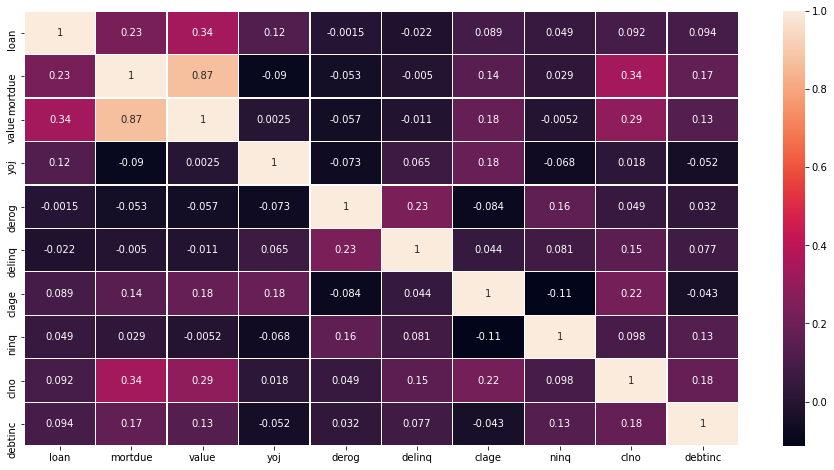

In [22]:
def heatmap(data, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)   
    sns.heatmap(data.corr(), annot=True, linewidths=.3, ax=ax)
    plt.show()

heatmap(data.drop(["bad"],axis=1))

Value ve mortdue incelendiğinnde 0.87 korelasyona sahip oldukları görülmektedir. Biri artarken diğerininde arttığı görülmektedir. Mal varlığı yüksek olan birisi ipoteğide fazla verip kredi skorunu etkileyebilir.

In [23]:
print("Most Correlated\n",correlation_df(data.drop(["bad"],axis=1)).sort_values(by="Corr", ascending=False).head(5),"\n")
print("Less Correlated\n",correlation_df(data.drop(["bad"],axis=1)).sort_values(by="Corr", ascending=True).head(5),"\n")

Most Correlated
    feature1 feature2      Corr
11  mortdue    value  0.873280
17  mortdue     clno  0.340139
2      loan    value  0.337453
25    value     clno  0.290439
35    derog   delinq  0.234706 

Less Correlated
    feature1 feature2      Corr
4      loan    derog  0.001463
20    value      yoj  0.002501
14  mortdue   delinq  0.004971
24    value     ninq  0.005191
22    value   delinq  0.011014 



### **2.2. Scatter Plot**

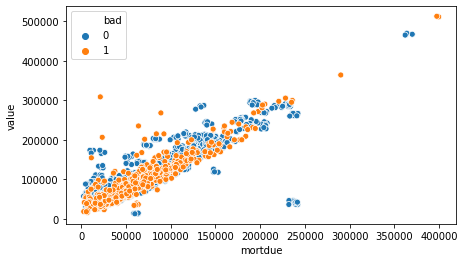

In [24]:
def scatterplot(x,y, hue, data, figsize=(7,4)):
    fig, ax = plt.subplots(figsize=figsize)        
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.show()

scatterplot("mortdue", "value", "bad", data)

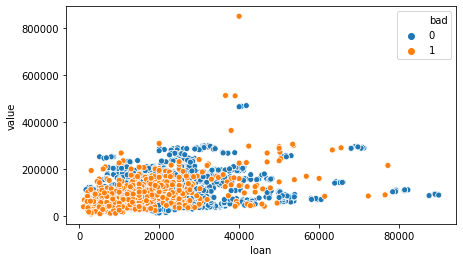

In [25]:
scatterplot("loan", "value", "bad", data)

Boxplot grafigi incelendiginde ise **loan, mortdue ve value** degiskenlerinde aykiri degerler oldugunu goruyoruz. Orjinal verileri manipule edip silmek istemedigimizden, verilere normalizasyon yontemini uyguluyoruz.

### **2.3. Box Plot**

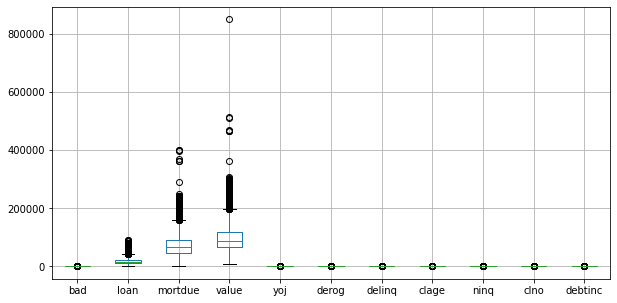

In [26]:
def boxplot(boxplot_df, figsize=(10,5)):
    plt.figure(figsize=figsize)
    boxplot_df.boxplot()
    plt.show()

boxplot(data)

Histogram grafigi incelendiginde ise verilerin kesikli ve normal dagilimdan gelmedigini goruyoruz. Modelimizin daha iyi sonuc vermesi icin normalizasyon yontemlerinin uygulanmasi gerektigini uygun goruyoruz.

### **2.4. Histogram**

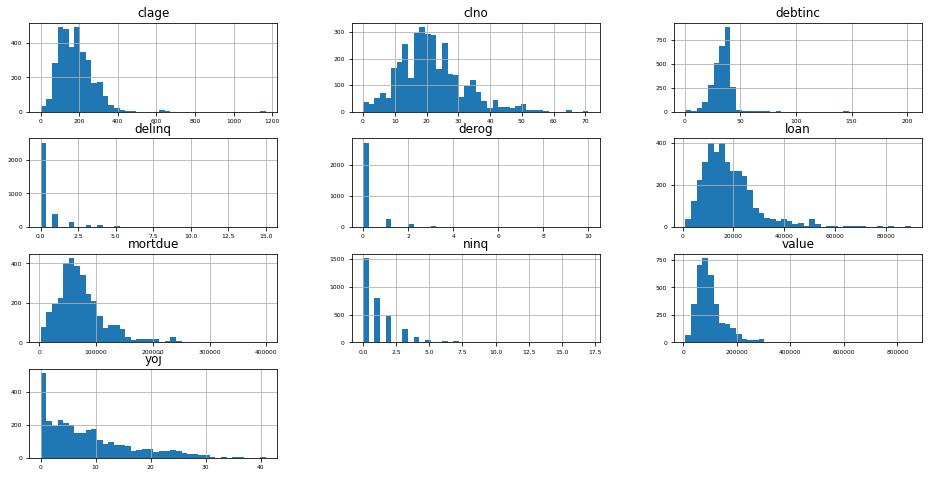

In [27]:
def histogram(datas, bins=40, xlabelsize=6, ylabelsize=6, figsize=(10,5)):
    datas.hist(figsize=figsize, bins=bins, xlabelsize=xlabelsize, ylabelsize=ylabelsize)
    plt.show()
    
histogram(data.drop(["bad"],axis=1), figsize=(16,8))

## **3. Data Preprocessing**

### **3.1. Data Imputation**
- value 
- clno
- reason
- job

Ancak dropna yaptigimizda datanin %45'sini silmis bulunuyoruz. Bu nedenle bazi degiskenleri silemk istmiyoruz. Imputation yontemine gidiyoruz. Burada %5'ten kucuk NULL oranina sahip degerleri median ile ve Unknown kategori ile dolduruyoruz.

### **3.1.1. With Imputation**

In [28]:
imputation_df = data.copy()
imputation_df["value"] = data["value"].fillna(data["value"].median())
imputation_df["clno"] = data["clno"].fillna(data["clno"].median())
imputation_df["reason"] = data["reason"].fillna("Unknown")
imputation_df["job"] = data["job"].fillna("Unknown")
print(imputation_df.count())

bad        3576
loan       3576
mortdue    3262
value      3576
reason     3576
job        3576
yoj        3264
derog      3149
delinq     3225
clage      3397
ninq       3273
clno       3576
debtinc    2809
dtype: int64


### **3.1.2. Without Imputation**

In [29]:
without_imputation_df = data.copy()
without_imputation_df.dropna(inplace=True)
print("Total Row: ",without_imputation_df.count()["bad"])
nulldata_check(without_imputation_df)

Total Row:  2018


,count,percentage
bad,0,0.0
loan,0,0.0
mortdue,0,0.0
value,0,0.0
reason,0,0.0
job,0,0.0
yoj,0,0.0
derog,0,0.0
delinq,0,0.0
clage,0,0.0


### **3.2. NULL Data Drop**

In [30]:
imputation_df.dropna(inplace=True)
print("Total Row: ",imputation_df.count()["bad"])
nulldata_check(imputation_df)

Total Row:  2114


,count,percentage
bad,0,0.0
loan,0,0.0
mortdue,0,0.0
value,0,0.0
reason,0,0.0
job,0,0.0
yoj,0,0.0
derog,0,0.0
delinq,0,0.0
clage,0,0.0


### **3.3. Numeric to Categoric Tranformation**

## --> Without imputation

In [31]:
imputation_df = without_imputation_df
imputation_df.head(3)

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
153,0,18200,94727.0,136877.0,DebtCon,Mgr,15.0,0.0,0.0,168.96,2.0,26.0,36.056
154,0,21700,79240.0,96784.0,DebtCon,Mgr,5.0,0.0,0.0,64.51,6.0,24.0,38.079
155,0,34100,241931.0,36486.0,DebtCon,Mgr,1.0,0.0,2.0,196.01,3.0,50.0,42.459


Burada degiskenleri bad hedef degiskenine gore crosstab ile analiz edip, kategori incelemesi gereceklestiriyoruz. Numerik olan degiskenlerin kateogrik olacak sekilde araliklarini belirliyoruz. 

#### **3.3.1 DEROG Degiskeni**

DEROG - Kredi borcunu zamaninda odemesi bakimindan musteri hakkinda zararli rapor sayisini inceledigimizde 0-2 arasinda zararli rapor sayisina sahip olan musteriler borclarini %77.5-92.5 arasinda odedigi goruluyor. Bu nedenle bunu uc kategoriye ayiriyoruz. 

- **RaporYok (0)**: 0 raporu olanlar genellikle %92 oraninda borcunu geri odemektedir. 
- **DusukRapor  (1-2)**: 1-2 arasinda zararli rapora sahip olanlar borcunu yuksek oranda odedigi gorulmektedir.
- **YuksekRapor (3-10)**: 3-10 arasinda zararli rapora sahip olanlar borcunu ortalamadan dusuk veya hic odemedigi goruluyor. Ancak bu kategoride elimizde yeterli (unbalanced) veri bulunmaktadir.rclarini geri oduyorlarmis. 

In [32]:
crosstab(imputation_df["bad"], imputation_df["derog"])

derog,0.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0
bad,,,,,,,,,
0,0.927043,0.835938,0.791667,0.416667,0.0,0.0,0.0,0.0,0.0
1,0.072957,0.164062,0.208333,0.583333,1.0,1.0,1.0,1.0,1.0


In [33]:
derog_replace = {0: "RaporYok", 1: "DusukRapor", 2: "DusukRapor", 3: "YuksekRapor", 4: "YuksekRapor",
                 4: "YuksekRapor",6: "YuksekRapor",7: "YuksekRapor",8: "YuksekRapor", 9: "YuksekRapor",
                10: "YuksekRapor"}
imputation_df = imputation_df.replace({"derog": derog_replace})

#### 3.3.2. DELINQ Degiskeni

DELINQ - Zamaninda odenmemis kredi sayisi bakimindan cogunlugunu 0,1,2 ve 3 odenmemis kredi sayisina sahip musterler olusturdugunu goruyoruz. Musterinin borcunu geri odemesi bakimindan 3'den fazla odenmemis odenmemis kredisi olanlari yuksek odenmemis kredi olarak isaretliyoruz. 

- **GecikmeYok (0)**: Sifir gecikme sayisina sahip olanlar borcunu %93.2 oraninda geri odemektedir. 
- **DusukGecikme (1-3)**: 1-3 arasi dusuk sayida gecikmis kredi sayisina sahip olan musteriler %72-86.5 arasinda borcunu odemektedir.  
- **YuksekGecikme (4-10)**: 4-10 arasi yuksek sayida gecikmis kredi sayisina sahip olan musteriler ise %0-50 arasinda borcunu geri odedigi gorulmektedir. Ancak 4'ten fazla gecikme sayisi olan musterilerin buyuk oranda borcunu hic odemedigi gorulmektedir.

In [34]:
crosstab(imputation_df["bad"], imputation_df["delinq"])

delinq,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,10.0
bad,,,,,,,,,
0,0.933294,0.871658,0.791667,0.72,0.538462,0.0,0.0,0.0,0.0
1,0.066706,0.128342,0.208333,0.28,0.461538,1.0,1.0,1.0,1.0


In [35]:
delinq_replace = {0: "GecikmeYok", 1: "DusukGecikme", 2: "DusukGecikme", 3: "DusukGecikme", 
                 4: "YuksekGecikme", 4: "YuksekGecikme",5: "YuksekGecikme",6: "YuksekGecikme",
                 7: "YuksekGecikme",8: "YuksekGecikme", 9: "YuksekGecikme", 10: "YuksekGecikme"}
imputation_df = imputation_df.replace({"delinq": delinq_replace})

#### 3.3.3. NINQ Degiskeni

NINQ - Kredi ile ilgili yapilan sorgu sayisi bakimindan incelendiginde, verinin cogunlugunu 0,1,2 ve 3 sorgu degerine sahip musteriler olusturmaktadir. Degiskeni kategorik hale getirmek icin musterilerin en az %70 oraninda borcunu geri odemesi ve hakkinda en fazla 4 kredi sorgu yapilmis olmasi varsayimlarini kabul ediyoruz. Kredi ile ilgili 0 hic sorgusu olmayan 1-3 arasi sorgu yapildiysa DusukSorgu, 4'ten fazla sorgularda ise YuksekSorgu olarak isaretliyoruz. 

- **SorguYok (0):** Sifir kredi sorgusu olan musterilerin kredisini %91.72 oraninda odedigi gorulmektedir.
- **DusukSorgu (1-4):** Kredi ile ilgili sorgu sayisi 1-4 arasi olanlar kredilerini %74.41-93.01 oaraninda zamaninda odedigi gorulmektedir. 
- **YuksekSorgu (5-13):** 4-13 sroguya sahip olanlar genellikle %74'ten az oranda borclarini geri oduyorlarmis. 

In [36]:
crosstab(imputation_df["bad"], imputation_df["ninq"])

ninq,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,13.0
bad,,,,,,,,,,,,,
0,0.920118,0.933333,0.92446,0.885714,0.75,0.6,0.642857,0.727273,1.0,0.666667,0.9,1.0,0.0
1,0.079882,0.066667,0.07554,0.114286,0.25,0.4,0.357143,0.272727,0.0,0.333333,0.1,0.0,1.0


In [37]:
ninq_replace = {0: "SorguYok", 1: "DusukSorgu", 2: "DusukSorgu", 3: "DusukSorgu", 
                 4: "DusukSorgu", 4: "YuksekSorgu",5: "YuksekSorgu",6: "YuksekSorgu", 7: "YuksekSorgu",
                 8: "YuksekSorgu", 9: "YuksekSorgu", 10: "YuksekSorgu", 11:"YuksekSorgu",
                12:"YuksekSorgu", 13:"YuksekSorgu" }
imputation_df = imputation_df.replace({"ninq": ninq_replace})

#### 3.3.4. YOJ Degiskeni

YOJ - Musterilerin mevcut is yerinde calistigi yil bakimindan incelendiginde, 0-10 yil arasinda musterilerin her yilda 100'den fazla musteri oldugunu goruyoruz. Bu nedenle musterileri mevcut is yili bakiminda 0-10, 11-20, 21-30, 31-40, 41-50 seklinde kategorilere ayiriyoruz. 

In [38]:
crosstab(imputation_df["bad"], imputation_df["yoj"])

yoj,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,35.0,36.0,41.0
bad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.909605,0.927007,0.872,0.843478,0.921053,0.871795,0.928571,0.934783,0.895349,0.920354,0.932039,0.921875,0.894737,0.848485,0.88,0.913043,0.941176,0.970588,0.928571,0.885714,0.971429,0.961538,1.0,0.966667,1.0,0.909091,0.909091,0.947368,0.916667,1.0,0.875,1.0,1.0,1.0,0.0
1,0.090395,0.072993,0.128,0.156522,0.078947,0.128205,0.071429,0.065217,0.104651,0.079646,0.067961,0.078125,0.105263,0.151515,0.12,0.086957,0.058824,0.029412,0.071429,0.114286,0.028571,0.038462,0.0,0.033333,0.0,0.090909,0.090909,0.052632,0.083333,0.0,0.125,0.0,0.0,0.0,1.0


In [39]:
yoj = []
for i in imputation_df["yoj"]:
    i = int(i)
    if(i >= 0 and i<=10):
        yoj.append("0-10")
    elif(i>10 and i<=20):
        yoj.append("11-20")
    elif(i>20 and i<=30):
        yoj.append("21-30")
    elif(i>30 and i<=40):
        yoj.append("31-40")
    else:
        yoj.append("41-50")

imputation_df["yoj"] = yoj

In [40]:
imputation_df.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
153,0,18200,94727.0,136877.0,DebtCon,Mgr,11-20,RaporYok,GecikmeYok,168.96,DusukSorgu,26.0,36.056
154,0,21700,79240.0,96784.0,DebtCon,Mgr,0-10,RaporYok,GecikmeYok,64.51,YuksekSorgu,24.0,38.079
155,0,34100,241931.0,36486.0,DebtCon,Mgr,0-10,RaporYok,DusukGecikme,196.01,DusukSorgu,50.0,42.459
156,0,8400,62989.0,76718.0,HomeImp,Mgr,0-10,RaporYok,DusukGecikme,131.47,SorguYok,22.0,29.200
157,0,17400,25859.0,43684.0,DebtCon,Mgr,11-20,DusukRapor,GecikmeYok,95.36,DusukSorgu,17.0,27.108


### 3.4. Dummy Transformation

In [41]:
num, category = numeric_categoric_variable(imputation_df)

Numeric Column  :
 ['bad', 'loan', 'mortdue', 'value', 'clage', 'clno', 'debtinc'] 

Categoric Column :
 ['reason', 'job', 'yoj', 'derog', 'delinq', 'ninq']


In [42]:
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

data_dummy = dummy_df(imputation_df, category)
num, cat = numeric_categoric_variable(data_dummy)
data_dummy.head(3)

Numeric Column  :
 ['bad', 'loan', 'mortdue', 'value', 'clage', 'clno', 'debtinc', 'reason_DebtCon', 'reason_HomeImp', 'job_Mgr', 'job_Office', 'job_Other', 'job_ProfEx', 'job_Sales', 'job_Self', 'yoj_0-10', 'yoj_11-20', 'yoj_21-30', 'yoj_31-40', 'yoj_41-50', 'derog_DusukRapor', 'derog_RaporYok', 'derog_YuksekRapor', 'delinq_DusukGecikme', 'delinq_GecikmeYok', 'delinq_YuksekGecikme', 'ninq_DusukSorgu', 'ninq_SorguYok', 'ninq_YuksekSorgu'] 

Categoric Column :
 []


,bad,loan,mortdue,value,clage,clno,debtinc,reason_DebtCon,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self,yoj_0-10,yoj_11-20,yoj_21-30,yoj_31-40,yoj_41-50,derog_DusukRapor,derog_RaporYok,derog_YuksekRapor,delinq_DusukGecikme,delinq_GecikmeYok,delinq_YuksekGecikme,ninq_DusukSorgu,ninq_SorguYok,ninq_YuksekSorgu
153,0,18200,94727.0,136877.0,168.96,26.0,36.056,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0
154,0,21700,79240.0,96784.0,64.51,24.0,38.079,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
155,0,34100,241931.0,36486.0,196.01,50.0,42.459,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0


### 3.5. Normalization

#### 3.5.1. Min-Max Normalization

In [43]:
data_minmax = normalization_minmax(data_dummy)
data_minmax.head(3)

,bad,loan,mortdue,value,clage,clno,debtinc,reason_DebtCon,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self,yoj_0-10,yoj_11-20,yoj_21-30,yoj_31-40,yoj_41-50,derog_DusukRapor,derog_RaporYok,derog_YuksekRapor,delinq_DusukGecikme,delinq_GecikmeYok,delinq_YuksekGecikme,ninq_DusukSorgu,ninq_SorguYok,ninq_YuksekSorgu
0,0.0,0.187075,0.227347,0.232520,0.144270,0.40625,0.228498,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.226757,0.188073,0.150633,0.054824,0.37500,0.242931,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.367347,0.600643,0.027481,0.167435,0.78125,0.274181,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 3.5.2. Without Normalization 

In [44]:
#data_minmax = data_dummy

# **3. Feature Selection**

### 3.1. Principal Component Analysis

In [45]:
data_pca = featureselection_pca(data_minmax,"bad", 0.9)
data_pca.head()

pca sonrası değişken sayısı:  9


,0,1,2,3,4,5,6,7,8,bad
0,-0.731283,-0.503780,0.859174,0.650631,-0.230217,0.336906,0.511953,-0.650730,-0.049518,0.0
1,-0.365154,-0.203467,-0.512842,0.168786,-0.002665,0.367648,0.721640,-0.703201,0.123162,0.0
2,-0.856140,0.139723,-0.027679,0.261835,1.261572,0.133774,0.076385,-0.982768,0.260247,0.0
3,1.052660,0.648982,-0.011003,-0.076870,1.172337,0.263991,0.259323,-1.009152,0.149988,0.0
4,-0.835913,-0.429815,0.870792,0.478768,0.175907,0.128854,1.512593,0.165357,-0.179672,0.0


### 3.2. Correlation based Feature Selection

In [46]:
data_corr = featureselection_corrcorr(data_minmax, "bad",0.6, 10)
data_corr.head()

,yoj_41-50,clage,derog_DusukRapor,delinq_DusukGecikme,ninq_YuksekSorgu,derog_RaporYok,delinq_GecikmeYok,derog_YuksekRapor,delinq_YuksekGecikme,debtinc,bad
0,0.0,0.144270,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.228498,0.0
1,0.0,0.054824,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.242931,0.0
2,0.0,0.167435,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.274181,0.0
3,0.0,0.112165,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.179582,0.0
4,0.0,0.081242,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.164656,0.0


### 3.3. RandomForest based Feature Selection

In [47]:
rf_params = {"max_depth": [2,5,8,10],
             "max_features": [2,3,4,5],
             "n_estimators": [10,50,100],
             "min_samples_split": [5,10]}

x= data_minmax.drop(["bad"], axis=1)
y = data_minmax["bad"]

data_rf = featureselection_randomforest(x,y, rf_params, 7) 
data_rf.head()

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.7min finished


,debtinc,loan,clage,clno,value,mortdue,delinq_YuksekGecikme,bad
0,0.228498,0.187075,0.144270,0.406250,0.232520,0.227347,0.0,0.0
1,0.242931,0.226757,0.054824,0.375000,0.150633,0.188073,0.0,0.0
2,0.274181,0.367347,0.167435,0.781250,0.027481,0.600643,0.0,0.0
3,0.179582,0.075964,0.112165,0.343750,0.109651,0.146862,0.0,0.0
4,0.164656,0.178005,0.081242,0.265625,0.042182,0.052704,0.0,0.0


# **4. Modelling (Algorithms)**

- Decision Tree
- Random Forest
- Neural Network
- Logistic Regression

## **4.1. DecisionTree Classifier**

### 4.1.1. PCA based FS

In [48]:
x = data_pca.drop(["bad"], axis=1)
y = data_pca["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

cart = DecisionTreeClassifier()
cart_model = cart.fit(xtrain, ytrain)
y_pred = cart_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.89505 
precision:  0.31579 
recall   :  0.30769 
f1-score :  0.31169

               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       466
         1.0       0.32      0.31      0.31        39

    accuracy                           0.90       505
   macro avg       0.63      0.63      0.63       505
weighted avg       0.89      0.90      0.89       505



### 4.1.2. Correlation based FS

In [49]:
x = data_corr.drop(["bad"], axis=1)
y = data_corr["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

cart = DecisionTreeClassifier()
cart_model = cart.fit(xtrain, ytrain)
y_pred = cart_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.90495 
precision:  0.39535 
recall   :  0.4359 
f1-score :  0.41463

               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       466
         1.0       0.40      0.44      0.41        39

    accuracy                           0.90       505
   macro avg       0.67      0.69      0.68       505
weighted avg       0.91      0.90      0.91       505



### 4.1.3. RandomForest based FS

In [50]:
x = data_rf.drop(["bad"], axis=1)
y = data_rf["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape


cart = DecisionTreeClassifier(max_depth=6, max_features=5)
cart_model = cart.fit(xtrain, ytrain)

y_pred = cart_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.95842 
precision:  0.95 
recall   :  0.48718 
f1-score :  0.64407

               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       466
         1.0       0.95      0.49      0.64        39

    accuracy                           0.96       505
   macro avg       0.95      0.74      0.81       505
weighted avg       0.96      0.96      0.95       505



### 4.1.4. Without Feature Selection

In [51]:
x = data_minmax.drop(["bad"], axis=1)
y = data_minmax["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

cart = DecisionTreeClassifier(max_depth=6, max_features=5)
cart_model = cart.fit(xtrain, ytrain)
y_pred = cart_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.92871 
precision:  0.71429 
recall   :  0.12821 
f1-score :  0.21739

               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       466
         1.0       0.71      0.13      0.22        39

    accuracy                           0.93       505
   macro avg       0.82      0.56      0.59       505
weighted avg       0.91      0.93      0.91       505



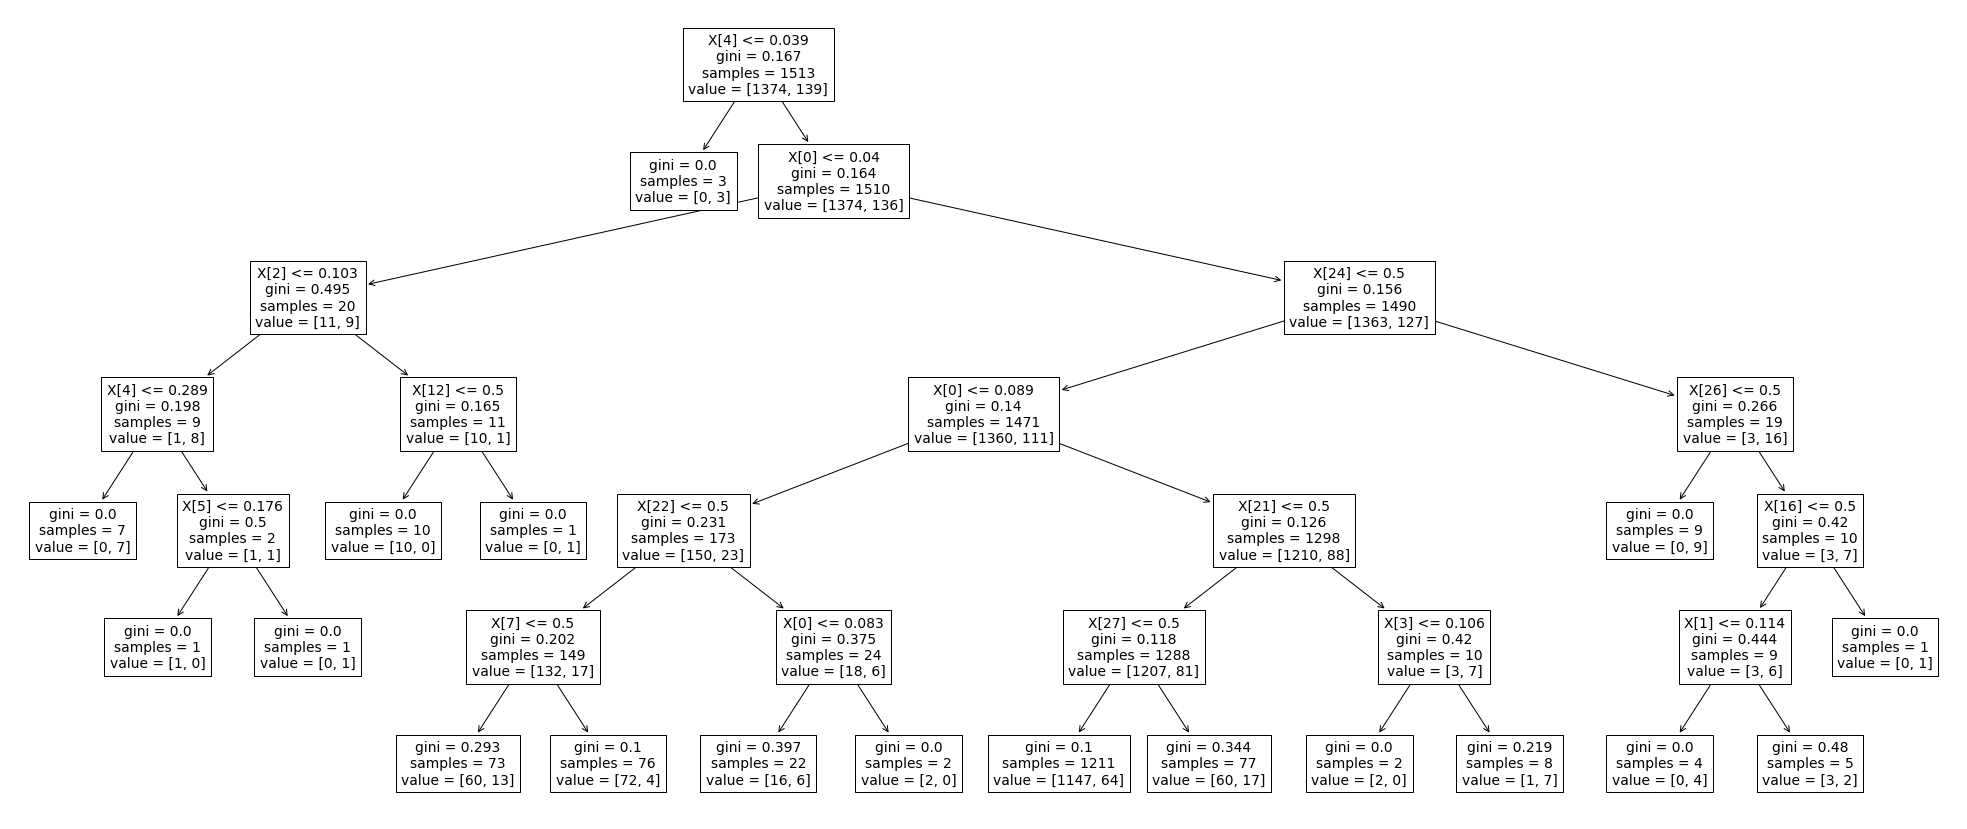

In [52]:
plt.figure(figsize=(35,15))
tree.plot_tree(cart_model);

## **4.2. RandomForest Classifier**

### 4.2.1. PCA based FS

In [53]:
x = data_pca.drop(["bad"], axis=1)
y = data_pca["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

rf = RandomForestClassifier()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.91683 
precision:  0.38462 
recall   :  0.12821 
f1-score :  0.19231

               precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       466
         1.0       0.38      0.13      0.19        39

    accuracy                           0.92       505
   macro avg       0.66      0.56      0.57       505
weighted avg       0.89      0.92      0.90       505



### 4.2.2. Correlation based FS

In [54]:
x = data_corr.drop(["bad"], axis=1)
y = data_corr["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape


rf = RandomForestClassifier()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.93465 
precision:  0.61538 
recall   :  0.41026 
f1-score :  0.49231

               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       466
         1.0       0.62      0.41      0.49        39

    accuracy                           0.93       505
   macro avg       0.78      0.69      0.73       505
weighted avg       0.93      0.93      0.93       505



### 4.2.3. RandomForest based FS

In [55]:
x = data_rf.drop(["bad"], axis=1)
y = data_rf["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape


rf = RandomForestClassifier()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.95644 
precision:  1.0 
recall   :  0.4359 
f1-score :  0.60714

               precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       466
         1.0       1.00      0.44      0.61        39

    accuracy                           0.96       505
   macro avg       0.98      0.72      0.79       505
weighted avg       0.96      0.96      0.95       505



### 4.2.4. Without Feature Selection

In [56]:
x = data_minmax.drop(["bad"], axis=1)
y = data_minmax["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape


rf = RandomForestClassifier()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.94653 
precision:  0.77273 
recall   :  0.4359 
f1-score :  0.55738

               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       466
         1.0       0.77      0.44      0.56        39

    accuracy                           0.95       505
   macro avg       0.86      0.71      0.76       505
weighted avg       0.94      0.95      0.94       505



## **4.3. NeuralNetwork Classifier**

### 4.3.1. PCA based FS

In [57]:
x = data_pca.drop(["bad"], axis=1)
y = data_pca["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPClassifier()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.91881 
precision:  0.33333 
recall   :  0.05128 
f1-score :  0.08889

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.33      0.05      0.09        39

    accuracy                           0.92       505
   macro avg       0.63      0.52      0.52       505
weighted avg       0.88      0.92      0.89       505



### 4.3.2. Correlation based FS

In [58]:
x = data_corr.drop(["bad"], axis=1)
y = data_corr["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPClassifier()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.92277 
precision:  0.5 
recall   :  0.12821 
f1-score :  0.20408

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.50      0.13      0.20        39

    accuracy                           0.92       505
   macro avg       0.72      0.56      0.58       505
weighted avg       0.90      0.92      0.90       505



### 4.3.3. RandomForest based FS

In [59]:
x = data_rf.drop(["bad"], axis=1)
y = data_rf["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPClassifier()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.93069 
precision:  0.66667 
recall   :  0.20513 
f1-score :  0.31373

               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       466
         1.0       0.67      0.21      0.31        39

    accuracy                           0.93       505
   macro avg       0.80      0.60      0.64       505
weighted avg       0.92      0.93      0.91       505



### 4.3.4. Without Feature Selection

In [60]:
x = data_minmax.drop(["bad"], axis=1)
y = data_minmax["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPClassifier()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.93861 
precision:  0.75 
recall   :  0.30769 
f1-score :  0.43636

               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       466
         1.0       0.75      0.31      0.44        39

    accuracy                           0.94       505
   macro avg       0.85      0.65      0.70       505
weighted avg       0.93      0.94      0.93       505



## **4.4. Logistic Regression**

### 4.4.1. PCA based FS

In [61]:
x = data_pca.drop(["bad"], axis=1)
y = data_pca["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

clf = LogisticRegression(random_state=0)
clf_model = clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.92277 
precision:  0.0 
recall   :  0.0 
f1-score :  0.0

               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       466
         1.0       0.00      0.00      0.00        39

    accuracy                           0.92       505
   macro avg       0.46      0.50      0.48       505
weighted avg       0.85      0.92      0.89       505



### 4.4.2. Correlation based FS

In [62]:
x = data_corr.drop(["bad"], axis=1)
y = data_corr["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

clf = LogisticRegression(random_state=0)
clf_model = clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.92079 
precision:  0.44444 
recall   :  0.10256 
f1-score :  0.16667

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.44      0.10      0.17        39

    accuracy                           0.92       505
   macro avg       0.69      0.55      0.56       505
weighted avg       0.89      0.92      0.90       505



### 4.4.3. RandomForest based FS

In [63]:
x = data_rf.drop(["bad"], axis=1)
y = data_rf["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

clf = LogisticRegression(random_state=0)
clf_model = clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.91881 
precision:  0.33333 
recall   :  0.05128 
f1-score :  0.08889

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.33      0.05      0.09        39

    accuracy                           0.92       505
   macro avg       0.63      0.52      0.52       505
weighted avg       0.88      0.92      0.89       505



### 4.3.4. Without Feature Selection

In [64]:
x = data_minmax.drop(["bad"], axis=1)
y = data_minmax["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

clf = LogisticRegression(random_state=0)
clf_model = clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

accuracy :  0.92079 
precision:  0.44444 
recall   :  0.10256 
f1-score :  0.16667

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.44      0.10      0.17        39

    accuracy                           0.92       505
   macro avg       0.69      0.55      0.56       505
weighted avg       0.89      0.92      0.90       505



## 4.5. Comparison Algorithms

- Decision Tree
- Random Forest 
- Neural Networks
- Logistic Regression

In [65]:
models = [cart, rf, mlp, clf]
x = data_rf.drop(["bad"], axis=1)
y = data_rf["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)

algorithms = ["DecisionTree", "RandomForest","NeuralNetwork","LogisticRegression"]
metrics = ["Accuracy", "Precision", "Recall", "f1-Score"]
accuracy = []

for i in models:
    model = i.fit(xtrain,ytrain)
    y_pred = model.predict(xtest)
    acc = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1score = f1_score(ytest, y_pred)
    accuracy.append([acc, precision, recall, f1score])

pd.DataFrame(accuracy, columns=metrics, index=algorithms)

,Accuracy,Precision,Recall,f1-Score
DecisionTree,0.948515,0.933333,0.358974,0.518519
RandomForest,0.948515,0.842105,0.410256,0.551724
NeuralNetwork,0.930693,0.666667,0.205128,0.313725
LogisticRegression,0.918812,0.333333,0.051282,0.088889


# **5. Model Tuning**
- Finding best parameters using GridSearch

Tuning yaparken modelling kisminda en iyi basariyi veren Feature Selection yontemi baz alinarak gerceklestirilmistir. 

In [ ]:
x = data_rf.drop(["bad"], axis=1)
y = data_rf["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1585, 7), (529, 7), (1585,), (529,))

### **5.1. DecisionTree Tuning**

In [ ]:
def DecisionTreeTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = DecisionTreeClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.criterion = grid_cv_model.best_params_["criterion"]
    model.max_depth = grid_cv_model.best_params_["max_depth"] 
    model.max_features = grid_cv_model.best_params_["max_features"]
    model.min_samples_split= grid_cv_model.best_params_["min_samples_split"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
%time
start = timeit.default_timer()
dt_params = {"criterion": ["gini", "entropy"],
             "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20],
             "max_features": [2,3,5,6,7,"auto", "sqrt", "log2"],
             "min_samples_split": [5,7,10,15,20,25,30,50,100]}

ytest, y_pred, model, best_params = DecisionTreeTuning(xtrain, ytrain, xtest, ytest, dt_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Fitting 10 folds for each of 2160 candidates, totalling 21600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 10664 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 19720 tasks      | elapsed:  2.0min


accuracy :  0.92817 
precision:  0.7619 
recall   :  0.32653 
f1-score :  0.45714
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 5}


[Parallel(n_jobs=-1)]: Done 21600 out of 21600 | elapsed:  2.3min finished


In [ ]:
model.criterion = "entropy"
model.max_depth = 5
model.max_features = 3
model.min_samples_split= 5
model_tuned = model.fit(xtrain, ytrain)
y_pred = model_tuned.predict(xtest)

In [ ]:
model_tuned

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

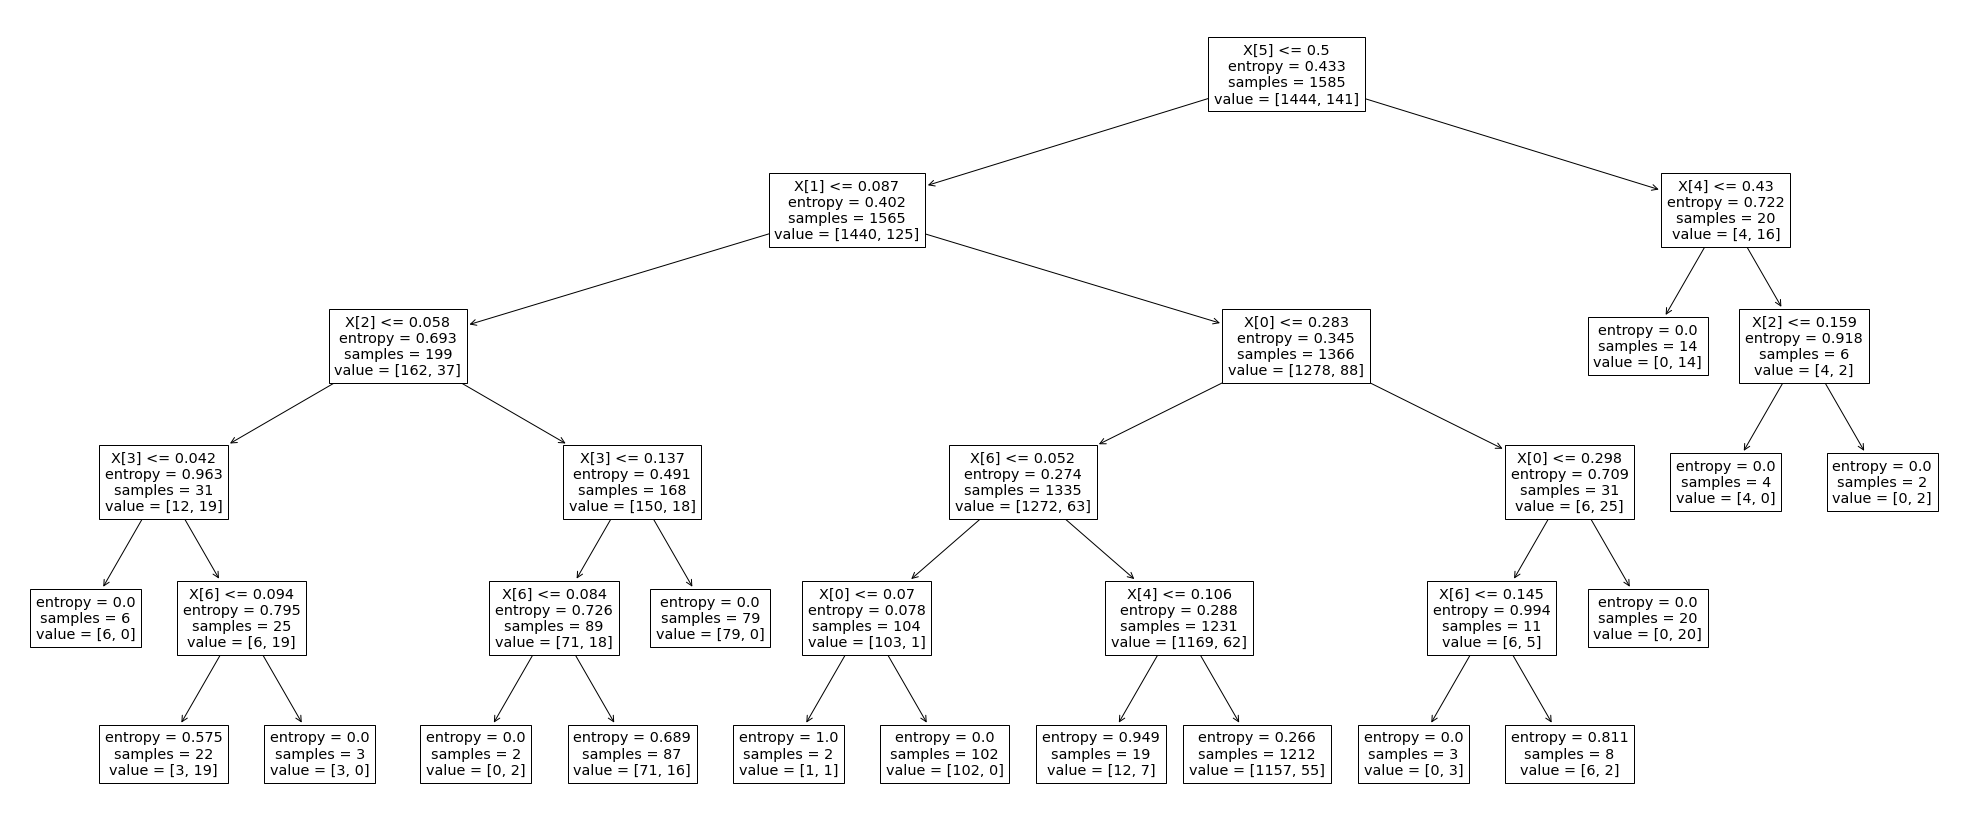

In [ ]:
plt.figure(figsize=(35,15))
tree.plot_tree(model_tuned);

### **5.2. RandomForest Tuning**

In [ ]:
def RandomForestTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = RandomForestClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_features = grid_cv_model.best_params_["max_features"] 
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.min_samples_split= grid_cv_model.best_params_["min_samples_split"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
start = timeit.default_timer()

rf_params = {"max_depth": [2,3,5,6,7,8,9,10,12,13,15],
             "max_features": [2,3,4,5,6,7],
             "n_estimators": [10,50,100,150],
             "min_samples_split": [5,10,15,20,30,50,100]}


ytest, y_pred, model, best_params = RandomForestTuning(xtrain,ytrain,xtest,ytest, rf_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

Fitting 10 folds for each of 1848 candidates, totalling 18480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1966 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2856 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3519 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4126 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 4815 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 5584 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 6435 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 7366 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 8379 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 9472 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 10647 tasks      

accuracy :  0.93951 
precision:  0.84 
recall   :  0.42857 
f1-score :  0.56757
{'max_depth': 12, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 10}

Passed Time:  4206.38664778


[Parallel(n_jobs=-1)]: Done 18480 out of 18480 | elapsed: 70.1min finished


### **5.3. Neural Network Tuning**

In [ ]:
def NeuralNetworkTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = MLPClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.alpha = grid_cv_model.best_params_["alpha"]
    model.hidden_layer_sizes = grid_cv_model.best_params_["hidden_layer_sizes"] 
    model.activation = grid_cv_model.best_params_["activation"]
    model.solver = grid_cv_model.best_params_["solver"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
start = timeit.default_timer()

mlp_param = {"alpha": [0.1,0.01,0.005],
             "hidden_layer_sizes": [(3,3), 
                                    (5,5), 
                                    (10,10), 
                                    (10,10,10)],
             "activation": ["relu","logistic"],
              "solver": ["lbfgs", "adam","sgd"]}

ytest, y_pred, model, best_params = NeuralNetworkTuning(xtrain,ytrain,xtest,ytest, mlp_param)
evaluation_metrics(ytest, y_pred)
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.9min finished


accuracy :  0.93195 
precision:  0.69697 
recall   :  0.46939 
f1-score :  0.56098
{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'lbfgs'}

Passed Time:  233.02350004100026


### **5.4. Logistic Regression**

In [ ]:
def LogisticTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = LogisticRegression()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.penalty = grid_cv_model.best_params_["penalty"]
    model.solver = grid_cv_model.best_params_["solver"] 
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
start = timeit.default_timer()

log_param = {"penalty": ["l1","l2", "elasticnet"],
              "solver": ["lbfgs", "liblinear","sag", "newton"]}

ytest, y_pred, model, best_params = LogisticTuning(xtrain,ytrain,xtest,ytest, log_param)
evaluation_metrics(ytest, y_pred)
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


accuracy :  0.92079 
precision:  0.42857 
recall   :  0.07692 
f1-score :  0.13043
{'penalty': 'l1', 'solver': 'liblinear'}

Passed Time:  0.6353861689999576


[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
